In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import sympy as sym

In [2]:
def lagrangian_interpolation(f,q):
    return lambda x : np.dot(np.transpose(lagrangian_interpolation_matrix(x,q)),f(q))

def omega_tensor(q):
    _n = q.shape[0]-1
    return lambda x : np.product([x-q[i] for i in xrange(_n+1)], axis = 0)
    

The estimate we want to check:

$$
|| f -p || \leq ||f^{n+1}||_\infty \frac{||w(x)||_\infty}{(n+1)!}
$$

in order to do so we need to define, simbolic and numerical functions. [`Sympy`]() is a very useful package to handle symbolic expressions and to export them to numerical functions. A the beginnnig of this notebook it is imported with the command: `import sympy as sym`. Let's define a simple function:

**Hint:** Try to plat around, derivatives integrals...

In [3]:
t = sym.symbols('t')
sf = sym.sin(2.*sym.pi*t) # sf, simbolic function.
print(sf)

sin(2.0*pi*t)


To make this function *digestible* by numpy we use the simple command `nf = sym.lambdify(t,f, 'numpy')`

In [4]:
f = sym.lambdify(t,sf, 'numpy')
print(f)
print(f(np.array([0,.25])))

<function <lambda> at 0x10b0d0668>
[ 0.  1.]


We aim at controlling all of the pieces of the inequality above, plot how terms behave with the degree, and see what happens `:)`

Good thing is to start from the beginning and control the term $||f-p||_\infty$. We recall that:
$$
p = \mathcal{L}^n f := \sum_{i=0}^n f(x_i) l^n_i(x),
$$

with

$$
l^n_i(x) := \prod_{j=0, j\neq i}^n \frac{(x-x_j)}{(x_i-x_j)}  \qquad
i = 0, \dots, n.
$$

Let's implment this guy. We want to fill the matrix `Ln` with $n+1$ rows and as many colums as the number of points where we evaluate the funtion. A good idea would be to collect the few operations in a function, like this one:
```python
def lagrangian_interpolation_matrix(x,q):
    ...
    return Ln
```
so that we can recalli whenever we need it.

**Hint:** I wouldn't call myself a good programmer, but I do my best to be like that. First construct the code in the main section of your program, run it, check that it works, then collect the precious commmands you wrote in an elegant function.

### Step 0

```python
n = 3
q = np.linspace(0,1,n+1)

x = np.linspace(0,1,2**4+1)

Ln = np.zeros((n+1, len(x)))

for i in xrange(n+1):
    Ln[i] = np.product([ (x-q[j])/(q[i]-q[j]) for j in xrange(n+1) if j != i], axis=0)

_ = pl.plot(x,Ln.T)
```

In [5]:
def lagrangian_interpolation_matrix(x,q):
    n = q.shape[0]-1
    Ln = np.zeros((n+1, len(x)))

    for i in xrange(n+1):
        Ln[i] = np.product([ (x-q[j])/(q[i]-q[j]) for j in xrange(n+1) if j != i], axis=0)
        
    return Ln

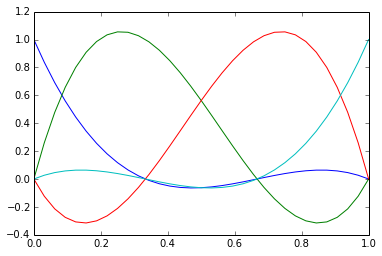

In [6]:
n = 3
q = np.linspace(0,1,n+1)

x = np.linspace(0,1,2**5+1)

Ln = lagrangian_interpolation_matrix(x,q)

_ = pl.plot(x,Ln.T)

From the previous lecture we know that the mathemathical expression:
$$
\mathcal{L}^nf := \sum_{i=0}^n f(x_i) l^n_i(x) 
$$

Can be easyly translated into the `numpy` line:
```python
Ln.T.dot(f(x))
```
Let's give it a try:


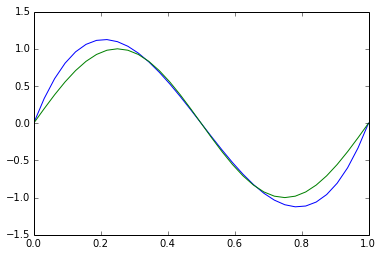

In [7]:
#print(Ln.shape)
#print(f(x).shape)
_ = pl.plot(x,Ln.T.dot(f(q)))
_ = pl.plot(x,f(x),'g')

Ok this works, but wouldn't it be good to have a code that looks like mathemathics? In this way it should be easer to debug.. Mathemattics looks like: $\mathcal{L}^nf$. And code:

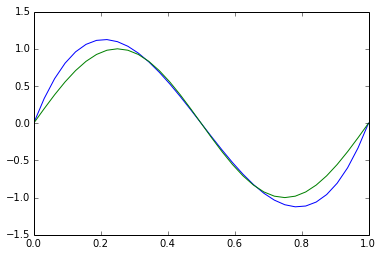

In [8]:
Lf = lambda x : lagrangian_interpolation_matrix(x,q).T.dot(f(q))

_ = pl.plot(x,Lf(x)) # isn't this looking better?
_ = pl.plot(x,f(x),'g')

We need a very simple function to evaluate the norm infinity of a function $||\cdot||_\infty$:

In [9]:
def linfty_norm(fun,a=0,b=1,nn=12):
    xx = np.linspace(a,b,2**nn+1)
    return np.amax(np.absolute(fun(xx)))

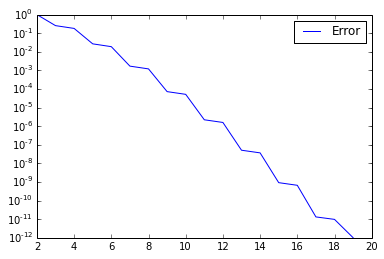

In [10]:
error = lambda x : f(x) - Lf(x)

test_degrees = np.arange(2,20)
test_errors = []

for n in test_degrees:
    q = np.linspace(0,1,n+1)
    test_errors.append(linfty_norm(error))

h1 = pl.semilogy(test_degrees,test_errors,label = 'Error')
_ = pl.legend()


In [ ]:
def compute_error_estimate(symf, maxgrade=20, npoints=1025, a=0, b=1):
    x = np.linspace(a,b,npoints)

    # numpy array
    nf = sym.lambdify(t,f, 'numpy') 

    pl.figure(figsize=[10,5])



    for n in xrange(2,maxgrade):
        # The interpolation points
        q = np.linspace(a,b,n+1)
    
        l = lagrangian_interpolation(nf,q)
    
        df = sym.diff(f,t,n+1)
        dnf = sym.lambdify(t,df, 'numpy')
        w = omega_tensor(q)
    
        lhs_linfty = linfty_norm(lambda x : nf(x)-l(x),a,b)
        df_linfty = linfty_norm(lambda x : dnf(x)-l(x),a,b)
        w_linfty = linfty_norm(lambda x : w(x),a,b )
        w_linfty /= np.math.factorial(n+1)
    
        rhs_linfty = df_linfty * w_linfty

        #figure(figsize=[10,5])
        _ = pl.semilogy (n,lhs_linfty, 'ro')
        #_ = pl.semilogy(n,df_linfty, 'y.') # linfty norm of the n+1 derivative
        #_= pl.semilogy(n,w_linfty, 'b+') # linfty norm of w(x)/(n+1)!
        _= pl.semilogy(n,rhs_linfty, 'g*')
    

    # plot the interpolation at the LAST iteration
    pl.figure(figsize=[10,5])
    _ = pl.plot(x, nf(x))
    _ = pl.plot(x, l(x))
    _ = pl.plot(q, nf(q), 'ro')
    

In [ ]:

t = sym.symbols('t')

f = sym.sin(2.*sym.pi*t)


compute_error_estimate(f,20,1025,0,1)

f = 1/(1+t*t)
compute_error_estimate(f,20,1025,-8,8)